## Manuscript Figure 2 - 10X Multiome results

I. [Comparing correlation of single-cell and pseudo-bulk data](#f2b)  

II. The graph-based correlation avoids potential false positives by two strategy:  
   1. It cares about graph dependence of features, lower the value of pairs not enriched in the graph  
        a. [L and Pearson's r behavior in the whole dataset](#f2c1)  
        b. [L and Pearson's r behavior in one or few clusters](#f2c2)  
        c. [L and Pearson's r behavior in false positives](#f2d)  
   2. It poses single-cell-specific significance test   
        a. [Calculate p values in the two methods](#f2e)


In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns
import time
sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


### Comparing correlation of single-cell and pseudo-bulk data <a name="f2b"></a>

In [2]:
# Load single-cell and pseudo-bulk data
ad_pb_all = ad.read_h5ad('../data/10XMultiome/10XPBMC.all.pseudo.h5ad')
ad_sc_all = ad.read_h5ad('../data/10XMultiome/10XPBMC.all.sc.h5ad')

# select the nearest peaks upstream of each gene
peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]

ad_pb_all.uns['peaks_nearby'] = peaks_nearby.copy()
ad_sc_all.uns['peaks_nearby'] = peaks_nearby.copy()

In [3]:
# calculate L and r
import multiome.graph_measure as graph_measure
ad_pb_all = graph_measure.Global_L(ad_pb_all, permutations=0)
ad_pb_all = graph_measure.Global_Pearson(ad_pb_all, p_value=False)

ad_sc_all = graph_measure.Global_L(ad_sc_all, permutations=0)
ad_sc_all = graph_measure.Global_Pearson(ad_sc_all, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']
Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby_sc = ad_sc_all.uns['peaks_nearby'].copy()
peaks_nearby_pb = ad_pb_all.uns['peaks_nearby'].copy()


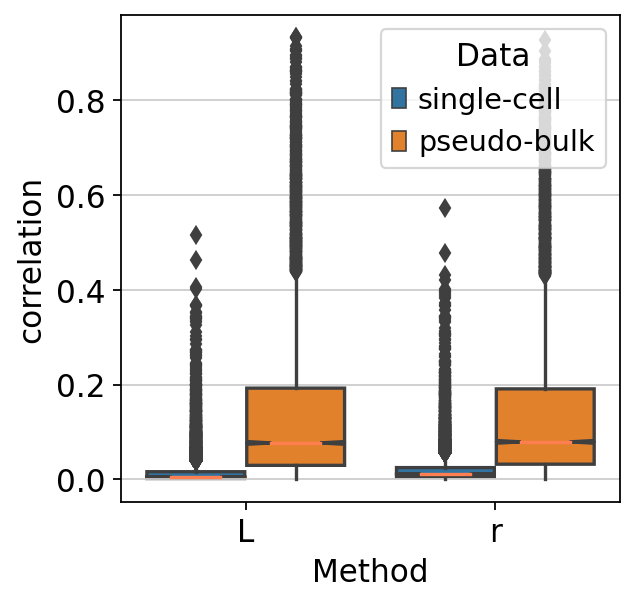

In [5]:
promoter_cor = pd.DataFrame({'correlation': peaks_nearby_sc['L'].abs().tolist() + peaks_nearby_sc['r'].abs().tolist() + \
                            peaks_nearby_pb['L'].abs().tolist() + peaks_nearby_pb['r'].abs().tolist(),
                            'Data': ['single-cell']*peaks_nearby_sc.shape[0]*2 + ['pseudo-bulk']*peaks_nearby_pb.shape[0]*2,
                            'Method':np.tile(np.repeat(['L'],peaks_nearby_sc.shape[0]).tolist() + np.repeat(['r'],peaks_nearby_sc.shape[0]).tolist(),2)})

ax = sns.boxplot(
    data=promoter_cor, x="Method", y='correlation',
    notch=True, showcaps=False,
    hue="Data",
    #flierprops={"marker": "x"},
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
#ax.set_ylim([0, 0.2])   

In [6]:
promoter_cor['dataset'] = '10X'

In [7]:
promoter_cor.to_csv('results/10X.sc_vs_pseudo.csv',index=False)

### L and Pearson's r behavior in the whole dataset <a name="f2c1"></a>

In [2]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_all = ad.read_h5ad('../data/10XMultiome/10XPBMC.all.pseudo.h5ad')
ad_pb_all = graph_measure.Morans_I(ad_pb_all)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
40.158s past


In [3]:
# Calculate L and r for genes and its nearest peaks

peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]
ad_pb_all.uns['peaks_nearby'] = peaks_nearby.copy()

ad_pb_all = graph_measure.Global_L(ad_pb_all, permutations=0)
ad_pb_all = graph_measure.Global_Pearson(ad_pb_all, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby['MoranI.gene'] = ad_pb_all.var.loc[peaks_nearby['genes'].to_numpy(),'Morans.I'].to_numpy()

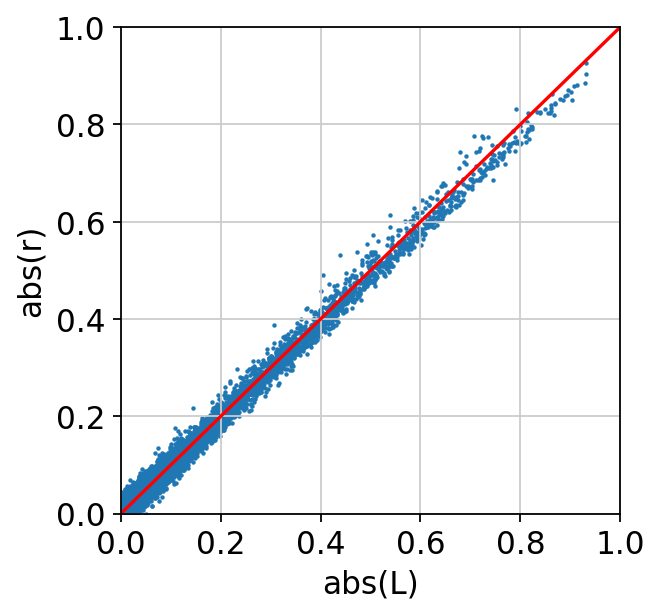

In [5]:
peaks_nearby['absL'] = peaks_nearby['L'].abs()
peaks_nearby['absr'] = peaks_nearby['r'].abs()

peaks_nearby.plot.scatter(x='absL',
                          y='absr',
                          #c='MoranI.gene',
                          s=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("abs(L)")
plt.ylabel("abs(r)")
plt.axline((0, 0), slope=1, color='r')
#plt.show()
plt.savefig('plots/figure2B1.pdf',dpi=300)
plt.show()

In [6]:
sp.stats.pearsonr(peaks_nearby['absL'],peaks_nearby['absr'])

PearsonRResult(statistic=0.9956170676850531, pvalue=0.0)

### L and Pearson's r behavior in one or few clusters  <a name="f2c2"></a>

When it turns to cluster analysis, correlations without embedding enrichment (correlation not of study intersts / biological variance) are higher with P than L. This is essential to detect and drop such kind of false positives, such as cell cycle regulatory info.

In [2]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_ct = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')
ad_pb_ct = graph_measure.Morans_I(ad_pb_ct)

Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
8.294s past


In [3]:
# Calculate L and r
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]

ad_pb_ct.uns['peaks_nearby'] = peaks_nearby.copy()

ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=0)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby['MoranI.gene'] = ad_pb_ct.var.loc[peaks_nearby['genes'].to_numpy(),'Morans.I'].to_numpy()

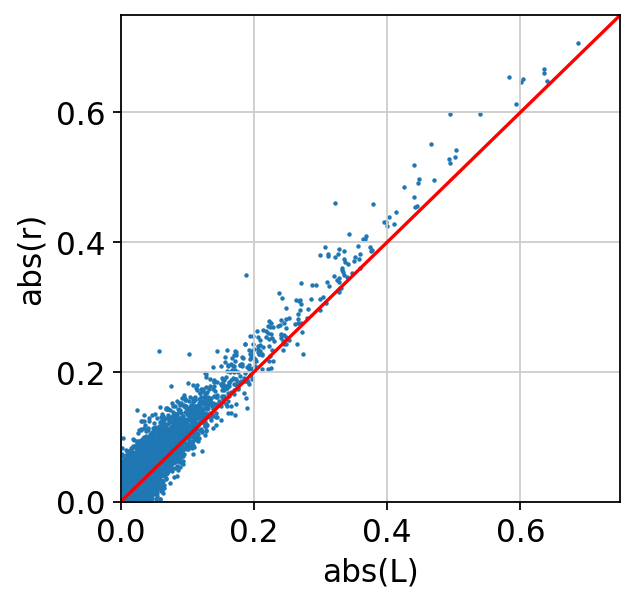

In [5]:
peaks_nearby['absL'] = peaks_nearby['L'].abs()
peaks_nearby['absr'] = peaks_nearby['r'].abs()

peaks_nearby.plot.scatter(x='absL',
                          y='absr',
                          #c='MoranI.gene',
                          s=1)
plt.xlim(0,0.75)
plt.ylim(0,0.75)
plt.xlabel("abs(L)")
plt.ylabel("abs(r)")
plt.axline((0, 0), slope=1, color='r')

In [6]:
sp.stats.pearsonr(peaks_nearby['absL'],peaks_nearby['absr'])

PearsonRResult(statistic=0.9421939646000057, pvalue=0.0)

#### Cell cycle genes example <a name="f2d"></a>

Human cell cycle gene list: https://www.gsea-msigdb.org/gsea/msigdb/cards/KEGG_CELL_CYCLE

In [8]:
ad_pb_ct = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')
cell_cycle = ['CDK2','CDK4','CDK6','CDK7','CDKN1A','CDKN1B','STAG1','CDKN1C','CDKN2A','CDKN2B','CDKN2C','CDKN2D','ANAPC10','MAD2L2','STAG2','PTTG2','GADD45G','DBF4','YWHAQ','CHEK1','CHEK2','CREBBP','GADD45A','E2F1','E2F2','E2F3','E2F4','E2F5','EP300','ORC6','ORC3','CDC26','ABL1','ANAPC13','SMC1B','SFN','GSK3B','ANAPC2','ANAPC4','HDAC1','HDAC2','MAD2L1','SMAD2','SMAD3','SMAD4','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MDM2','MYC','GADD45B','ATM','WEE2','ORC1','ORC2','ORC4','ORC5','PCNA','FZR1','ANAPC5','ANAPC7','ANAPC11','PLK1','ATR','PRKDC','RAD21','RB1','RBL1','RBL2','CCND1','ANAPC1','SKP1','SKP2','','','BUB1','BUB1B','TFDP1','TFDP2','TGFB1','TGFB2','TGFB3','TP53','TTK','SKP1P2','','WEE1','YWHAB','YWHAE','YWHAG','YWHAH','YWHAZ','ZBTB17','SMC1A','CDC7','CDC45','MAD1L1','CUL1','CCNB3','CDC14B','CDC14A','CDC23','CDC16','CCNA2','CCNA1','CCNB1','CCND2','CCND3','CCNE1','CCNH','PKMYT1','SMC3','CCNB2','CCNE2','BUB3','PTTG1','ESPL1','CDK1','CDC6','CDC20','CDC25A','CDC25B','CDC25C','CDC27','RBX1']
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['genes'].isin(cell_cycle),:]
ad_pb_ct.uns['peaks_nearby'] = peaks_nearby.copy()


In [9]:
import multiome.graph_measure as graph_measure
ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=0)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


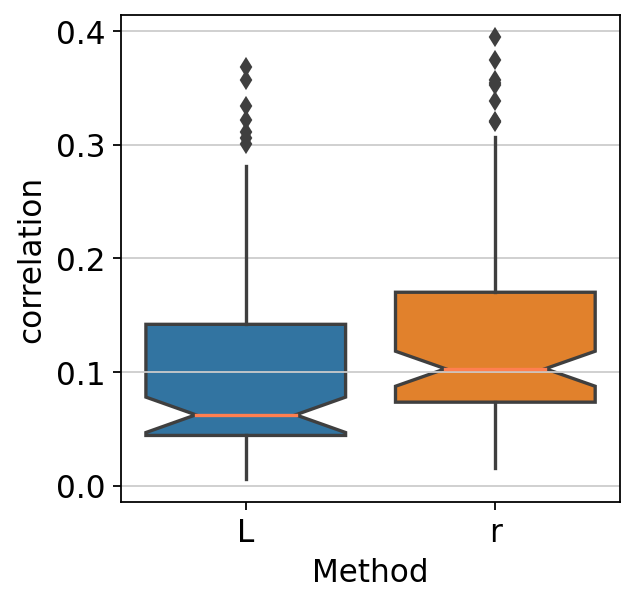

In [10]:
cc_prt = ad_pb_ct.uns['peaks_nearby'].copy() #.loc[peaks_nearby_pb['pRegion']==1]
cc_prt['absr'] = cc_prt['r'].abs()
cc_prt = cc_prt.sort_values('absr', ascending=False)
cc_prt = cc_prt.loc[~cc_prt['genes'].duplicated()]
promoter_cor = pd.DataFrame({'correlation': cc_prt['L'].abs().tolist() + cc_prt['r'].abs().tolist(),
                             'Method':np.repeat(['L'],cc_prt.shape[0]).tolist() + np.repeat(['r'],cc_prt.shape[0]).tolist()})

ax = sns.boxplot(
    data=promoter_cor, x="Method", y='correlation',
    notch=True, showcaps=False,
    #hue="Data",
    #flierprops={"marker": "x"},
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
#ax.set_ylim([0, 0.2])


In [11]:
promoter_cor['dataset'] = '10X'
promoter_cor.to_csv('results/10X.cell_cycle.csv',index=False)

### Calculate p values in the two methods <a name="f2e"></a>

In [2]:
import multiome.graph_measure as graph_measure
ad_pb_ct = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')


In [3]:
%%time
# Calculate L and r
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()

ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=999, percent=0.1)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=True)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Calculating p-values...
Calculating FDR...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']
CPU times: user 5h 57min 40s, sys: 48min 46s, total: 6h 46min 26s
Wall time: 53min 24s


In [4]:
# some examples
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby.loc[peaks_nearby['genes'].isin(['CDC14B','MTA3','TARBP1','YWHAZ','CDC14A','SMAD3']) & 
                 peaks_nearby['peaks'].isin(['chr9-96618413-96620300','chr2-42492664-42495435',
                                             'chr1-234486742-234489041','chr8-100899654-100902466',
                                             'chr1-100459059-100460078','chr15-67080415-67084384']
                                           )]

,genes,peaks,tss_dist,pRegion,tts_dist,gBody,L,L.p_value,L.FDR,gene.pct,peak.pct,r,r.p_value,r.FDR
3138,CDC14A,chr1-100459059-100460078,114567.0,0,-60709.0,1,0.135267,4.341833e-03,0.044535,0.751919,0.073273,0.177353,1.350403e-15,2.856206e-14
4118,TARBP1,chr1-234486742-234489041,-8712.0,0,-96578.0,0,0.189403,2.471645e-05,0.000694,0.162596,0.071528,0.187809,2.468399e-17,5.876902e-16
16624,MTA3,chr2-42492664-42495435,-520.0,1,-262898.0,0,0.209295,8.720436e-07,0.000039,0.138521,0.211445,0.232098,7.198144e-26,2.651152e-24
48586,YWHAZ,chr8-100899654-100902466,52328.0,0,15463.0,0,0.140848,7.236985e-04,0.011486,0.592812,0.027913,0.186113,4.802552e-17,1.119809e-15
52204,CDC14B,chr9-96618413-96620300,487.0,0,-129115.0,1,0.163769,8.157357e-06,0.000267,0.048151,0.133636,0.226500,1.104686e-24,3.854932e-23
80613,SMAD3,chr15-67080415-67084384,18636.0,0,-112774.0,1,0.159890,6.148765e-04,0.010053,0.288207,0.201675,0.185021,7.344667e-17,1.692976e-15


In [5]:
peaks_nearby.to_csv('results/10X.correlation.allpairs.csv', index=False)

In [6]:
peaks_nearby = pd.read_csv('results/10X.correlation.allpairs.csv')
peaks_nearby = peaks_nearby.loc[(peaks_nearby['tts_dist']<0) & (peaks_nearby['tts_dist']>-20000)]

peaks_nearby['-log10(L.q)'] = -np.log10(peaks_nearby['L.FDR'])
peaks_nearby['-log10(r.q)'] = -np.log10(peaks_nearby['r.FDR'])
cell_cycle = ['CDK2','CDK4','CDK6','CDK7','CDKN1A','CDKN1B','STAG1','CDKN1C','CDKN2A','CDKN2B','CDKN2C','CDKN2D','ANAPC10','MAD2L2','STAG2','PTTG2','GADD45G','DBF4','YWHAQ','CHEK1','CHEK2','CREBBP','GADD45A','E2F1','E2F2','E2F3','E2F4','E2F5','EP300','ORC6','ORC3','CDC26','ABL1','ANAPC13','SMC1B','SFN','GSK3B','ANAPC2','ANAPC4','HDAC1','HDAC2','MAD2L1','SMAD2','SMAD3','SMAD4','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MDM2','MYC','GADD45B','ATM','WEE2','ORC1','ORC2','ORC4','ORC5','PCNA','FZR1','ANAPC5','ANAPC7','ANAPC11','PLK1','ATR','PRKDC','RAD21','RB1','RBL1','RBL2','CCND1','ANAPC1','SKP1','SKP2','','','BUB1','BUB1B','TFDP1','TFDP2','TGFB1','TGFB2','TGFB3','TP53','TTK','SKP1P2','','WEE1','YWHAB','YWHAE','YWHAG','YWHAH','YWHAZ','ZBTB17','SMC1A','CDC7','CDC45','MAD1L1','CUL1','CCNB3','CDC14B','CDC14A','CDC23','CDC16','CCNA2','CCNA1','CCNB1','CCND2','CCND3','CCNE1','CCNH','PKMYT1','SMC3','CCNB2','CCNE2','BUB3','PTTG1','ESPL1','CDK1','CDC6','CDC20','CDC25A','CDC25B','CDC25C','CDC27','RBX1']
peaks_nearby['cell_cycle'] = peaks_nearby['genes'].isin(cell_cycle).astype(int)


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
cc_prt = peaks_nearby.loc[peaks_nearby['genes'].isin(cell_cycle)].copy()
cc_prt['absr'] = np.abs(cc_prt['r'])
cc_prt = cc_prt.sort_values('absr', ascending=False)
cc_prt = cc_prt.loc[~cc_prt['genes'].duplicated()]
#cc_prt = cc_prt.loc[cc_prt['r.FDR']<0.01]
cc_prt.shape

(67, 18)

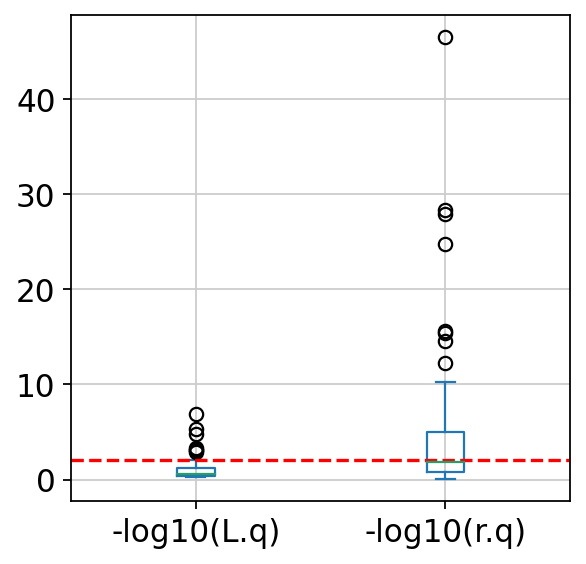

In [8]:
cc_prt.plot.box(column=['-log10(L.q)','-log10(r.q)'])
plt.axhline(y=2.0, color='r', linestyle='--')

In [9]:
cc_prt['dataset'] = '10X'
cc_prt.loc[:,['genes','peaks','L.FDR','r.FDR','dataset']].to_csv('results/10X.cc_pvalue.csv',index=False)

### GSEA with gene correlation ranks

In [2]:
cor_df = pd.read_csv('results/10X.correlation.allpairs.csv')

In [3]:
rank_L = cor_df.sort_values(by='L').copy()
rank_L = rank_L.loc[~rank_L['genes'].duplicated()]
rank_L[['L','genes']].to_csv('results/10X.cd4T.GeneRank_L.txt', index=False, header=False)

In [5]:
rank_r = cor_df.sort_values(by='r').copy()
rank_r = rank_r.loc[~rank_r['genes'].duplicated()]
rank_r[['r','genes']].to_csv('results/10X.cd4T.GeneRank_r.txt', index=False, header=False)